# Template to make plots comparing ICESat-2 and Imagery

In [1]:
from utils.oa import dataCollector
import numpy as np
import h5py
import matplotlib.pyplot as plt
import traceback
import ee
import toolshelf as t
from scipy.fft import fft, fftfreq, ifft
import pandas as pd
import timeit as ti
from pandas import Series as s

If needed, uncomment below to authenticate Earth Engine.

In [2]:
#ee.Authenticate()

## Paste API URLs from OpenAltimetry below

In [3]:
inputs = []
#inputs += [('Cook', 'gt3l', 'http://openaltimetry.org/data/api/icesat2/atl03?date=2020-11-16&minx=152.5116927878799&miny=-68.66606612894006&maxx=152.6581399201866&maxy=-68.60932596334501&trackId=817&beamName=gt3r&beamName=gt3l&outputFormat=json')]
#inputs += [('Amery', 'gt3r', 'http://openaltimetry.org/data/api/icesat2/atl03?date=2019-09-12&minx=72.6628933460874&miny=-68.74867386382803&maxx=72.77835977982862&maxy=-68.67672286446552&trackId=1163&beamName=gt3r&beamName=gt3l&outputFormat=json')]
inputs += [('Ross', 'gt1l', 'http://openaltimetry.org/data/api/icesat2/atl03?date=2022-02-02&minx=-170.47263882809312&miny=-78.77189963820707&maxx=-170.26880533262224&maxy=-78.67823736601781&trackId=648&beamName=gt1r&beamName=gt1l&outputFormat=json')]

## Download data and make plots

thiscrs = 'EPSG:3031' # antarctica stereographic
for shelf, gtx, url in inputs: 
    
    print('\n__________________________________\n%s' % shelf)
    rData = dataCollector(oaurl=url, beam=gtx)
    sceneIDS = aData.makeGEEmap()
    for j,scene_id in enumerate(sceneIDS):
        try: 
            outname = 'plots/' + shelf + '_%02i.jpg' % j
            fig = aData.plotDataAndMap(scene_id, crs=thiscrs, 
                                        title='ICESat-2 data over a rift on %s Ice Shelf' % shelf,
                                        skipdownload=False,
                                        plot_filename=outname)
        except:
            print(scene_id, 'failed.')
            traceback.print_exc()
    plt.close('all')

## MY Functions

TO DO:

GEOPHYSICAL CORRECTIONS
   

In [ ]:
isSeaward = (s03[0][0]<s03[0][100])
if (not isSeaward):
        print('Track orientation landward. Flipping track')

In [26]:
def findMelange(minLat, maxLat, myData):    
    #Gather ATL03 mélange from manually selected ATL06 mélange
    s03 = [myData.atl03.lat, myData.atl03.h]
    s06 = [myData.atl06.lat, myData.atl06.h]
    isSeaward = (s03[0][0]<s03[0][100])
    m06 = [s06[0][minLat:maxLat], s06[1][minLat:maxLat]]
    l0 = list(m06[0])[0]
    l1 = list(m06[0])[-1]
    if (not isSeaward):
        print('Track orientation landward. Flipping track')
        l0, l1 = l1, l0
    # l0 < m03 < l1
    m03 = s03[0][s03[0]>l0]
    m03 = m03[m03<l1]
    m03 = [pd.Series(list(m03)), pd.Series([s03[1][i] for i in m03.index[:]])]
    return s03, m03, s06, m06

def makePlot(data, title=None, mlims=None):
    # Plot IS2 data

    fig, ax = plt.subplots(figsize=[5, 3])

    #function needs updating first
    s03, m03, s06, m06 = findMelange(mlims[0], mlims[1], data)

    ax.scatter(s03[0], s03[1], s=2, color='black', alpha=0.1, label='ATL03')
    ax.scatter(m03[0], m03[1], s=2, color='tomato', alpha=0.1)
    ax.plot(s06[0], s06[1], label='ATL06', linewidth=1.5, color='orange')
    ax.plot(m06[0], m06[1], label='Mélange', linewidth=1.5, color='red')

    heights = data.atl03.h[data.atl03.conf != 'Noise']
    y_min1 = np.min(heights)
    y_max1 = np.max(heights)
    maxprods = data.atl06.h.max()
    minprods = data.atl06.h.min()
    hrange = maxprods - minprods
    y_min2 = minprods - hrange * 0.5
    y_max2 = maxprods + hrange * 0.5
    y_min = np.nanmin((y_min1, y_min2))
    y_max = np.nanmax((y_max1, y_max2))

    x_min = data.atl06.lat.min()
    x_max = data.atl06.lat.max()

    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

    # label the axes
    ax.set_title(title)
    ax.set_xlabel('latitude')
    ax.set_ylabel('elevation (m)')

    # add a legend
    ax.legend(loc='lower right')

    # add some text to provide info on what is plotted
    info = 'ICESat-2 track {track:d}-{beam:s} on {date:s}\n({lon:.4f}E, {lat:.4f}N)'.format(track=data.track, 
                                                                                            beam=data.beam, 
                                                                                            date=data.date, 
                                                                                            lon=np.mean(data.lonlims), 
                                                                                            lat=np.mean(data.latlims))
    infotext = ax.text(0.03, 0.03, info,
                       horizontalalignment='left', 
                       verticalalignment='bottom', 
                       transform=ax.transAxes,
                       fontsize=5,
                       bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))


def makeHist(data, bins=10, title=None, xlims=None, ylims=None):
    fig, ax = plt.subplots(figsize=[5, 3])
    ax.hist(data, bins, edgecolor='black', color='#ffd08a', density=True)
    ax.set_title(title)
    ax.set_ylabel('count')
    ax.set_xlabel('elevation (m)')
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.tick_params(which='both', direction='in')

    
def makePSD(data, title=None, xlims=None, ylims=None):
    nx = len(data[0])
    k = np.arange(-nx/2, nx/2)
    ft = np.fft.fftshift(np.fft.fft(data[1]))
    fig, ax = plt.subplots(figsize=[5, 3])
    ax.plot(k, 20*np.log10((ft*ft.conj()).real/nx), label='Mélange FFT', linewidth=1.5, color='black')
    #ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_ylabel('Amplitude (dB)')
    ax.set_xlabel('Frequency (a.u.)')
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_xticks([])



## Get Data

In [34]:
#Get data
inputs = []
inputs += [('Ross', 'gt1l', 'http://openaltimetry.org/data/api/icesat2/atl03?date=2022-02-02&minx=-170.47263882809312&miny=-78.77189963820707&maxx=-170.26880533262224&maxy=-78.67823736601781&trackId=648&beamName=gt1r&beamName=gt1l&outputFormat=json')]

thiscrs = 'EPSG:3031' # antarctica stereographic
for shelf, gtx, url in inputs: 
    
    print('\n__________________________________\n%s' % shelf)
    rData = dataCollector(oaurl=url, beam=gtx)
    rData.requestData(verbose=True)
    
#Get data
inputs = []
inputs += [('Amery', 'gt3r', 'http://openaltimetry.org/data/api/icesat2/atl03?date=2019-09-12&minx=72.6628933460874&miny=-68.74867386382803&maxx=72.77835977982862&maxy=-68.67672286446552&trackId=1163&beamName=gt3r&beamName=gt3l&outputFormat=json')]

thiscrs = 'EPSG:3031' # antarctica stereographic
for shelf, gtx, url in inputs: 
    
    print('\n__________________________________\n%s' % shelf)
    aData = dataCollector(oaurl=url, beam=gtx)
    aData.requestData(verbose=True)
    
inputs = []
inputs += [('Cook', 'gt3l', 'http://openaltimetry.org/data/api/icesat2/atl03?date=2020-11-16&minx=152.5116927878799&miny=-68.66606612894006&maxx=152.6581399201866&maxy=-68.60932596334501&trackId=817&beamName=gt3r&beamName=gt3l&outputFormat=json')]
thiscrs = 'EPSG:3031' # antarctica stereographic
for shelf, gtx, url in inputs: 
    
    print('\n__________________________________\n%s' % shelf)
    cData = dataCollector(oaurl=url, beam=gtx)
    cData.requestData(verbose=True)


__________________________________
Ross
---> requesting ATL03 data... Done
---> requesting ATL06 data... Done
---> requesting ATL08 data... Done

__________________________________
Amery
---> requesting ATL03 data... Done
---> requesting ATL06 data... Done
---> requesting ATL08 data... Done

__________________________________
Cook
---> requesting ATL03 data... Done
---> requesting ATL06 data... Done
---> requesting ATL08 data... Done


## Ross

In [28]:
mlims = [190, 360]
rs03, rm03, rs06, rm06 = findMelange(mlims[0], mlims[1], rData)

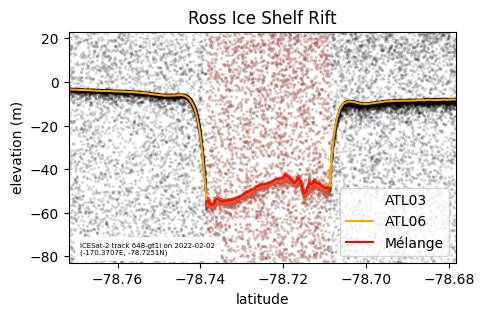

<Figure size 640x480 with 0 Axes>

In [33]:
title = 'Ross Ice Shelf Rift'
mlims = [190, 360]
makePlot(rData, title, mlims)
plt.show()
plt.savefig('RossIS2.pdf', dpi=100, bbox_inches='tight')

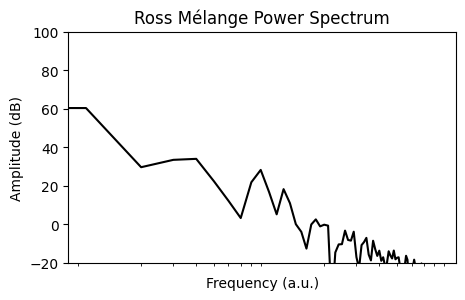

In [30]:
title='Ross Mélange Power Spectrum'
ylims=[-20, 100]

makePSD(rm06, title, ylims=ylims)
plt.savefig('RossPSD.pdf', dpi=100, bbox_inches='tight')

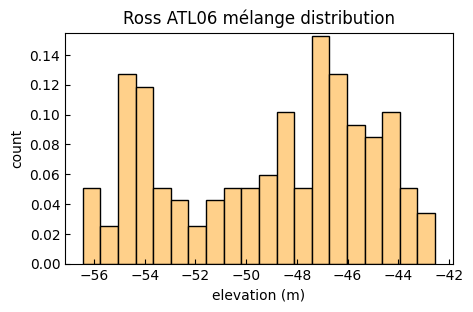

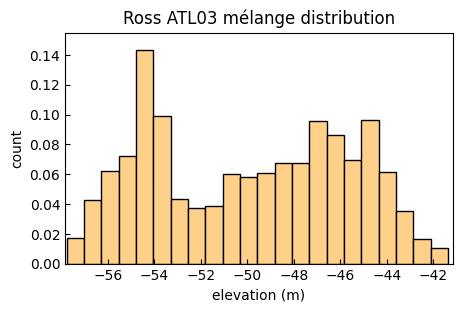

In [14]:
# ATL06 Histogram

bins = 20
title='Ross ATL06 mélange distribution'
ylims = [0, 0.155]
makeHist(rm06[1], bins, title=title, ylims=ylims)
plt.savefig('Ross06Dist.pdf', dpi=100, bbox_inches='tight')

#Subset ATL03 mélange even more using bounds set bu ATL06 with a 10% buffer

buffer = (rm06[1].max() - rm06[1].min())*0.1
xlims = [rm06[1].min()-buffer, rm06[1].max()+buffer]
rm03Temp = rm03[1][rm03[1]>xlims[0]]
rm03Temp = rm03Temp[rm03Temp<xlims[1]]

title='Ross ATL03 mélange distribution'
makeHist(rm03Temp, bins+2, title=title, ylims=ylims, xlims=xlims)
plt.savefig('Ross03Dist.pdf', dpi=100, bbox_inches='tight')

## Amery

Track orientation landward. Flipping track
Track orientation landward. Flipping track


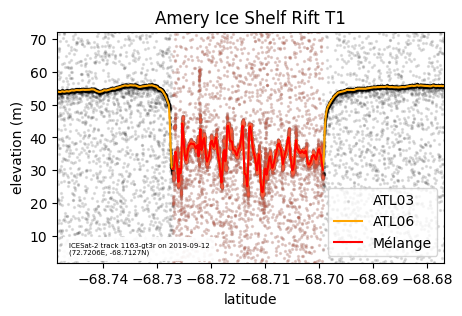

In [31]:
title = 'Amery Ice Shelf Rift T1'
mlims = [127, 285]
as03, am03, as06, am06 = findMelange(mlims[0], mlims[1], aData)

makePlot(aData, title, mlims)
plt.savefig('AmeryIS2.pdf', dpi=100, bbox_inches='tight')

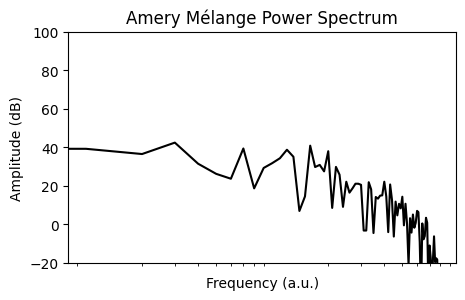

In [20]:
title='Amery Mélange Power Spectrum'
ylims=[-20, 100]

makePSD(am06, title, ylims=ylims)
plt.savefig('AmeryPSD.pdf', dpi=100, bbox_inches='tight')

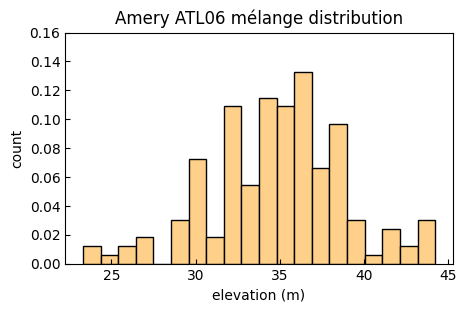

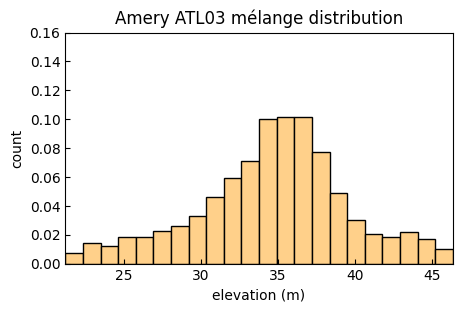

In [21]:
# Mélange histogram

title='Amery ATL06 mélange distribution'
ylims = [0, 0.16]
bins=20
makeHist(am06[1], bins, title=title, ylims=ylims)

#Subset ATL03 mélange even more using bounds set bu ATL06 with a 10% buffer

buffer = (am06[1].max() - am06[1].min())*0.1
xlims = [am06[1].min()-buffer, am06[1].max()+buffer]
am03Temp = am03[1][am03[1]>xlims[0]]
am03Temp = am03Temp[am03Temp<xlims[1]]

title = 'Amery ATL03 mélange distribution'
#same ylims as above
makeHist(am03Temp, bins+2, title=title, xlims=xlims, ylims=ylims)
plt.savefig('Amery03Dist.pdf', dpi=100, bbox_inches='tight')

## Cook

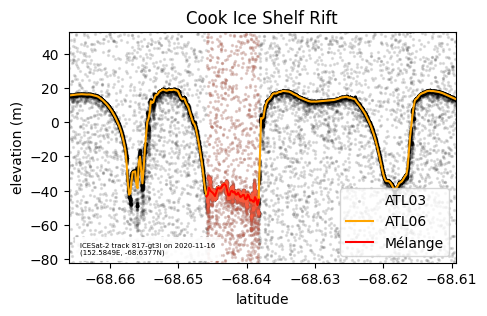

In [32]:
title = 'Cook Ice Shelf Rift'
mlims = [114, 157]
cs03, cm03, cs06, cm06 = findMelange(mlims[0], mlims[1], cData)

makePlot(cData, title, mlims)
plt.savefig('CookIS2.pdf', dpi=100, bbox_inches='tight')

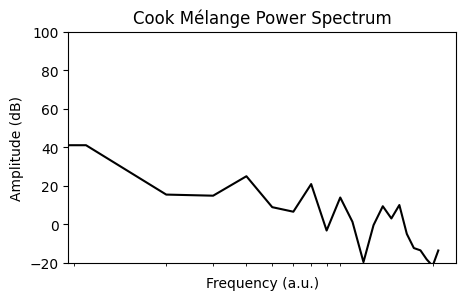

In [25]:
title='Cook Mélange Power Spectrum'
ylims=[-20, 100]

makePSD(cm06, title, ylims=ylims)
plt.savefig('CookPSD.pdf', dpi=100, bbox_inches='tight')

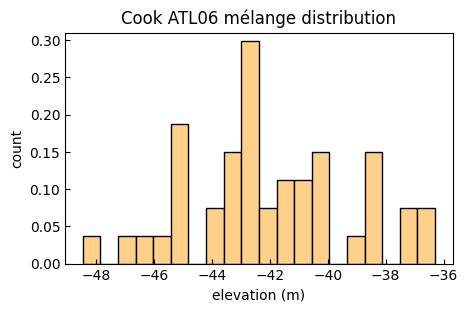

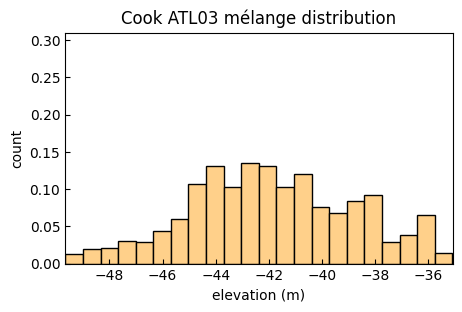

In [27]:
# Mélange histogram

title='Cook ATL06 mélange distribution'
ylims = [0, 0.31]
bins=20
makeHist(cm06[1], bins, title=title, ylims=ylims)

#Subset ATL03 mélange even more using bounds set bu ATL06 with a 10% buffer

buffer = (cm06[1].max() - cm06[1].min())*0.1
xlims = [cm06[1].min()-buffer, cm06[1].max()+buffer]
cm03Temp = cm03[1][cm03[1]>xlims[0]]
cm03Temp = cm03Temp[cm03Temp<xlims[1]]

title = 'Cook ATL03 mélange distribution'
#same ylims as above
makeHist(cm03Temp, bins+2, title=title, xlims=xlims, ylims=ylims)
plt.savefig('Cook03Dist.pdf', dpi=100, bbox_inches='tight')